In [64]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)

In [65]:
from scipy import stats
import statsmodels.api as sm
import statistics
from statsmodels.stats import weightstats
#from statsmodels.formula.api import ols
#from statsmodels.stats.anova import anova_lm

# import 'stats' package from scipy library
from scipy import stats

# import the functions to perform Chi-square tests
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import chisquare
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
# function to perform post-hoc test


# import function to perform post-hoc
import scikit_posthocs
from scipy import stats
from statsmodels.stats import weightstats
import random
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score,f1_score,precision_score,accuracy_score,confusion_matrix,roc_curve,roc_auc_score,classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
df_sample = pd.read_csv("df_last.csv")

## EDA

In [4]:
df_sample.head(3)

,Type,Late_delivery_risk,Customer City,Customer Id,Customer Segment,Customer Zipcode,Market,Order City,Order Country,Order Region,Order State,Order Status,Shipping Mode
0,DEBIT,1,Taylor,17,Consumer,48180.0,LATAM,Sorocaba,Brasil,South America,São Paulo,COMPLETE,Standard Class
1,TRANSFER,1,Caguas,8889,Consumer,725.0,Europe,Leicester,Reino Unido,Northern Europe,Inglaterra,PROCESSING,Standard Class
2,CASH,0,Lynwood,10701,Consumer,90262.0,USCA,San Luis Obispo,Estados Unidos,West of USA,California,CLOSED,Standard Class


In [5]:
df_sample.shape

(50000, 13)

In [6]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Type                50000 non-null  object 
 1   Late_delivery_risk  50000 non-null  int64  
 2   Customer City       50000 non-null  object 
 3   Customer Id         50000 non-null  int64  
 4   Customer Segment    50000 non-null  object 
 5   Customer Zipcode    50000 non-null  float64
 6   Market              50000 non-null  object 
 7   Order City          50000 non-null  object 
 8   Order Country       50000 non-null  object 
 9   Order Region        50000 non-null  object 
 10  Order State         50000 non-null  object 
 11  Order Status        50000 non-null  object 
 12  Shipping Mode       50000 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 5.0+ MB


## ROUGH MODELS 1

### Encoding :

* Target encoding <b> (probability encoding all except type and shipping mode as dummy</b>
* Models implemented <b> logit,navie bayes ,decision tree and random forest</b>

In [113]:
df_model_1 = df_sample.copy()

In [114]:
df_model_1.head(3)

,Type,Late_delivery_risk,Customer City,Customer Id,Customer Segment,Customer Zipcode,Market,Order City,Order Country,Order Region,Order State,Order Status,Shipping Mode
0,DEBIT,1,Taylor,17,Consumer,48180.0,LATAM,Sorocaba,Brasil,South America,São Paulo,COMPLETE,Standard Class
1,TRANSFER,1,Caguas,8889,Consumer,725.0,Europe,Leicester,Reino Unido,Northern Europe,Inglaterra,PROCESSING,Standard Class
2,CASH,0,Lynwood,10701,Consumer,90262.0,USCA,San Luis Obispo,Estados Unidos,West of USA,California,CLOSED,Standard Class


In [115]:
#Target Encode
def Target_encode_test(data,cols):
    d_map = {}
    for col in cols:
        cross = pd.crosstab(data[col],data["Late_delivery_risk"])
        cross["prob"] = cross[1]/(cross[1]+cross[0])
        d = {}
        for cat in cross.index:
            d[cat] = cross.loc[cat,"prob"]
        d_map[col] = d
    return d_map    

In [116]:
def map_categories_encode(data,dic):
    for col in dic.keys():
        data[col]= data[col].map(dic[col])

In [117]:
en_cols = df_model_1.columns.drop(["Late_delivery_risk","Type","Shipping Mode"])
Tar_encode_dict = Target_encode_test(df_model_1,en_cols)
map_categories_encode(df_model_1,Tar_encode_dict)

In [118]:
df_model_1.head(4)

,Type,Late_delivery_risk,Customer City,Customer Id,Customer Segment,Customer Zipcode,Market,Order City,Order Country,Order Region,Order State,Order Status,Shipping Mode
0,DEBIT,1,0.588235,0.428571,0.546311,0.588235,0.541360,0.666667,0.532937,0.534044,0.553704,0.571845,Standard Class
1,TRANSFER,1,0.546353,0.571429,0.546311,0.546353,0.557981,0.700000,0.534328,0.544673,0.538627,0.575902,Standard Class
2,CASH,0,0.518519,0.400000,0.546311,0.518519,0.537456,0.000000,0.540035,0.523765,0.526045,0.571559,Standard Class
3,CASH,1,0.546353,1.000000,0.546311,0.546353,0.553627,0.535714,0.574468,0.564974,0.535714,0.571559,Same Day


In [119]:
df_final = pd.get_dummies(df_model_1,drop_first=True)

### train_test_split

In [120]:
x = df_final.drop("Late_delivery_risk",axis=1)
y = df_final["Late_delivery_risk"]

In [121]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=34)
print(f"x_train {x_train.shape}")
print(f"x_test {x_test.shape}")
print(f"y_train {y_train.shape}")
print(f"y_test {y_test.shape}")

x_train (40000, 16)
x_test (10000, 16)
y_train (40000,)
y_test (10000,)


### BASE MODEL

* From Bussinees point of view we need to get a <b> good recall score  because when we prdict its an late delivery risk and its not then not a problem but when we say its not a late delivery risk and its actually a late delivery then its a problem.</b>
* So, we try to focus mainly on recall score and not on accuracy

# Naive Bayes

Test Recall: 0.9556695365451547
Train Recall: 0.9528495284952849


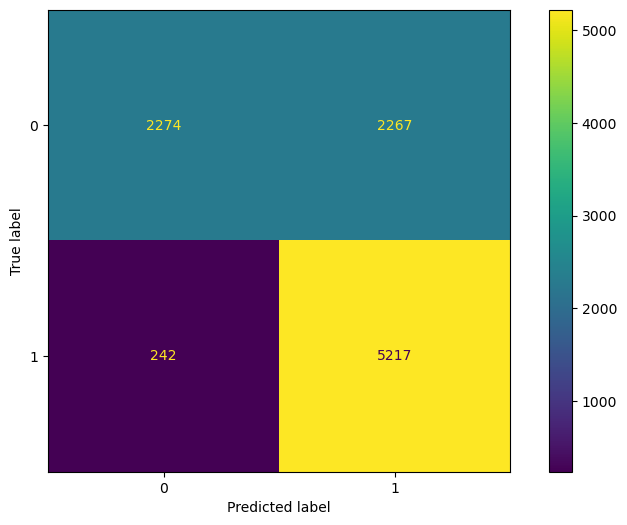

In [66]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Assume we have our input features in a variable called X and our labels in a variable called y
# Split the data into training and testing sets
# Create a Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

nb_classifier.fit(x_train,y_train)
y_pred_test = nb_classifier.predict(x_test)
y_pred_train = nb_classifier.predict(x_train)
nb_classifier.score(x_test,y_test)
print("Test Recall:", recall_score(y_test,y_pred_test))
print("Train Recall:", recall_score(y_train,y_pred_train))

#cm = confusion_matrix(y_test,y_pred_test)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test)
plt.show()

In [27]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.50      0.64      4541
           1       0.70      0.96      0.81      5459

    accuracy                           0.75     10000
   macro avg       0.80      0.73      0.73     10000
weighted avg       0.79      0.75      0.73     10000



* recall score is 96 for both the cases for Naive bayes algorithm

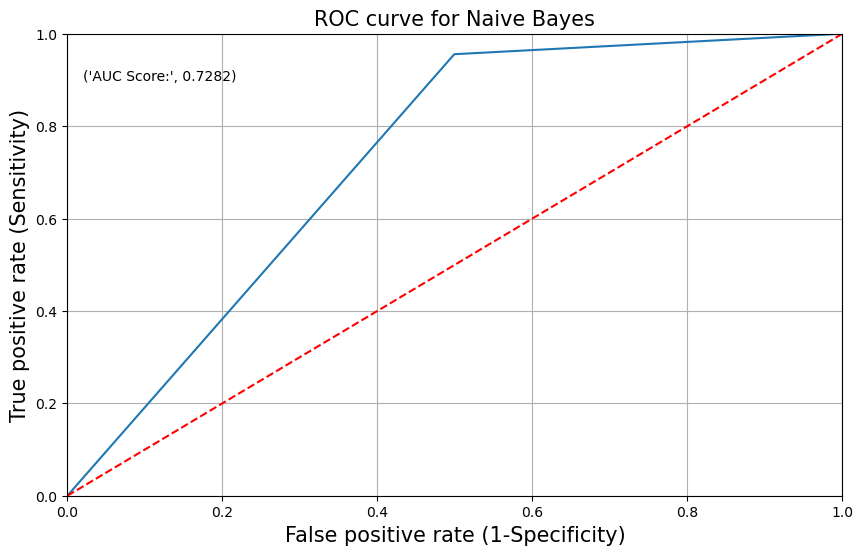

In [67]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr)
# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Naive Bayes', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(y_test, y_pred_test),4)))
                               
# plot the grid
plt.grid(True)

# Logistic

In [29]:
lg = sm.Logit(y_train,x_train).fit()
lg.summary()

Optimization terminated successfully.
         Current function value: 0.305381
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Late_delivery_risk   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39984
Method:                           MLE   Df Model:                           15
Date:                Thu, 20 Apr 2023   Pseudo R-squ.:                  0.5564
Time:                        20:02:39   Log-Likelihood:                -12215.
converged:                       True   LL-Null:                       -27535.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Customer City                   -0.1189      0.372     -0.319      0.750      -0.849       0.611
Customer Id                      6.2515      0.076     82.140      0.000       6.102       6.401
Customer Segment               -10.4364      1.873     -5.573      0.000     -14.107      -6.766
Customer Zipcode                -0.2337      0.287     -0.815      0.415      -0.796       0.328
Market                          -4.0320      2.169     -1.859      0.063      -8.282       0.218
Order City                       4.9340      0.148     33.314      0.000       4.644       5.224
Order Country                   -1.0293      0.553     -1.860      0.063      -2.114       0.055
Order Region                    -2.2896      1.369     -1.673      0.094      -4.972       0.393
Order State                      0.0135      0.253      0.053      0.957      -0.482       0.509
Order Status                    19.9702      1.253     15.938      0.000      17.514      22.426
Type_DEBIT                       0.0849      0.054      1.570      0.116      -0.021       0.191
Type_PAYMENT                    -0.0933      0.058     -1.611      0.107      -0.207       0.020
Type_TRANSFER                   -0.1121      0.058     -1.931      0.053      -0.226       0.002
Shipping Mode_Same Day          -7.6394      0.585    -13.062      0.000      -8.786      -6.493
Shipping Mode_Second Class      -6.1236      0.582    -10.513      0.000      -7.265      -4.982
Shipping Mode_Standard Class    -7.8997      0.582    -13.574      0.000      -9.040      -6.759
================================================================================================

Possibly complete quasi-separation: A fraction 0.11 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Train recall 0.8640608628308505
Test recall 0.8629785675032057


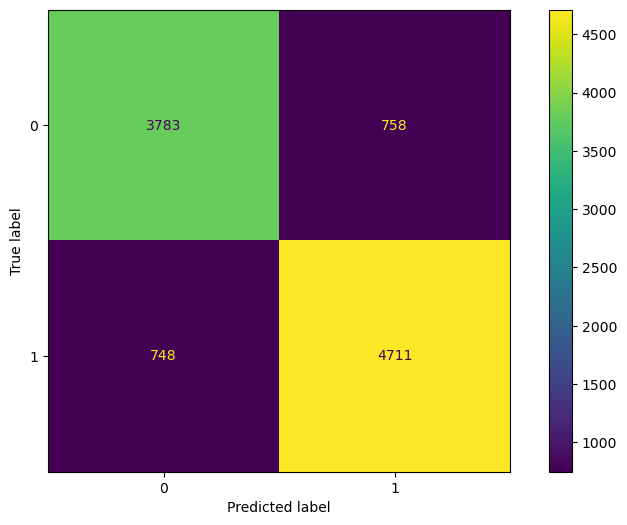

In [68]:
print(f"Train recall {recall_score(y_train,lg.predict(x_train).map(lambda x: 1 if x>0.5 else 0))}")
print(f"Test recall {recall_score(y_test,lg.predict(x_test).map(lambda x: 1 if x>0.5 else 0))}")
ConfusionMatrixDisplay.from_predictions(y_test,lg.predict(x_test).map(lambda x: 1 if x>0.5 else 0))
plt.show()

In [31]:
y_pred_test = lg.predict(x_test)
y_pred_test = [1 if i>0.5 else 0  for i in y_pred_test]
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      4541
           1       0.86      0.86      0.86      5459

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



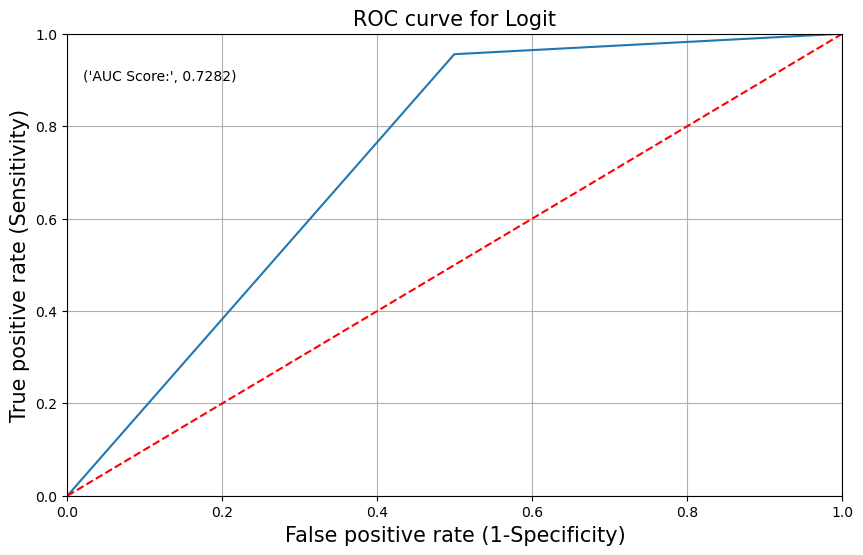

In [69]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr)
# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Logit', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(y_test, y_pred_test),4)))
                               
# plot the grid
plt.grid(True)

# Desicion Tree

Test recall 0.8919215973621543
Train recall 0.9974944193886384


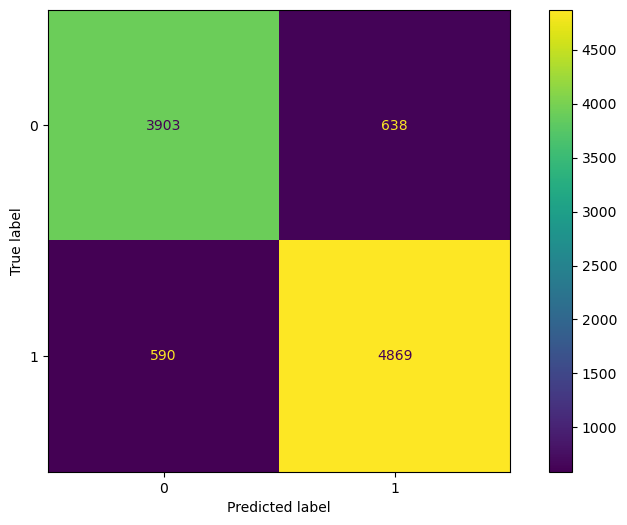

In [70]:
# Create a decision tree classifier object
clf = DecisionTreeClassifier()

# Fit the classifier to the training data
clf.fit(x_train, y_train)

# Predict the classes of the testing data
y_pred_test = clf.predict(x_test)
y_pred_train = clf.predict(x_train)
# Print the accuracy of the model
print("Test recall", recall_score(y_test,y_pred_test))
print("Train recall", recall_score(y_train,y_pred_train))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test)
plt.show()

* Overfitting condition for decision tree as train recall score(0.96) is more than test recall score(0.87)

In [34]:
y_pred_test = lg.predict(x_test)
y_pred_test = [1 if i>0.5 else 0  for i in y_pred_test]
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      4541
           1       0.86      0.86      0.86      5459

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



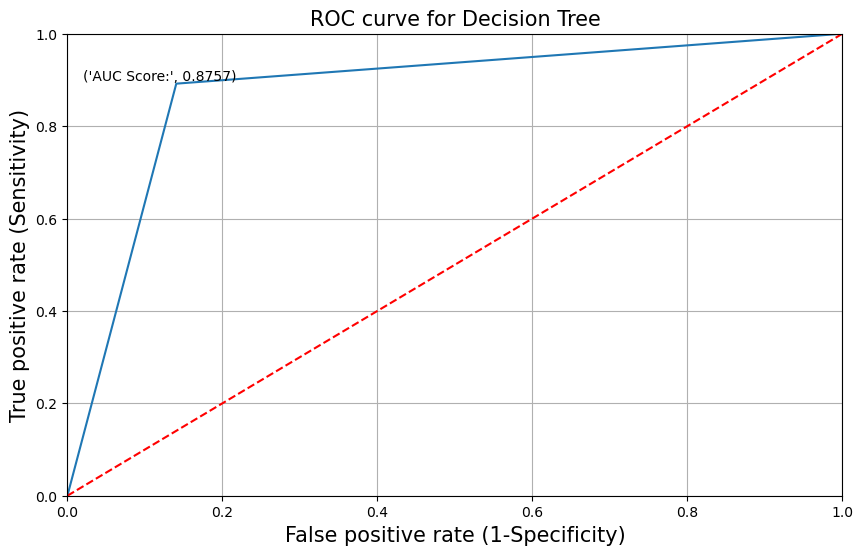

In [71]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr)
# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Decision Tree', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(y_test, y_pred_test),4)))
                               
# plot the grid
plt.grid(True)

### Feature Importance of Desicion Tree

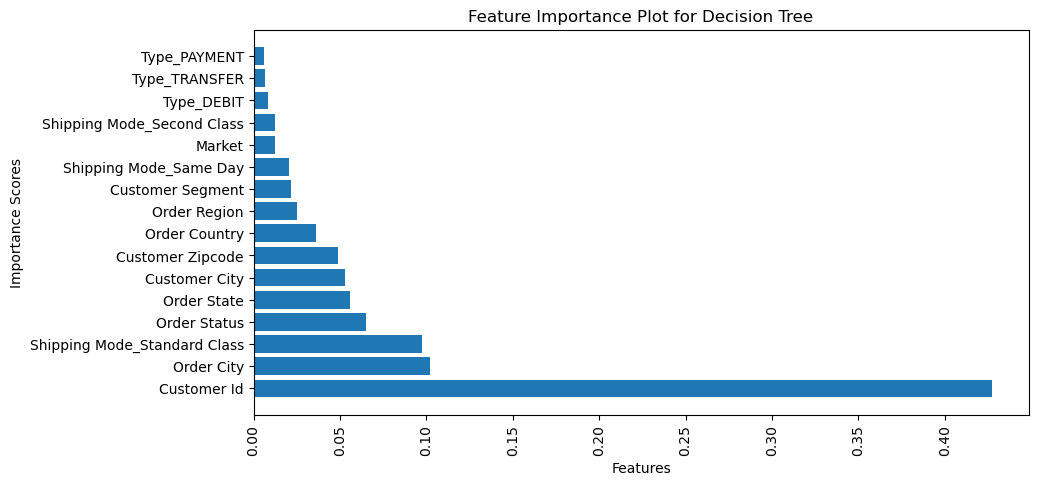

In [72]:
# Create a decision tree classifier object
clf = DecisionTreeClassifier()

# Fit the classifier to the training data
clf.fit(x_train, y_train)
importance_scores = clf.feature_importances_
feature_names = list(x_train.columns)
sorted_indices = importance_scores.argsort()[::-1]
importance_scores_sorted = importance_scores[sorted_indices]
feature_names_sorted = [feature_names[i] for i in sorted_indices]
plt.figure(figsize=(10, 5))
plt.barh(feature_names_sorted, importance_scores_sorted)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Scores")
plt.title("Feature Importance Plot for Decision Tree")
plt.show()

# Random Forest

Test Recall 0.9045612749587837
Train Recall 0.9981777595553734


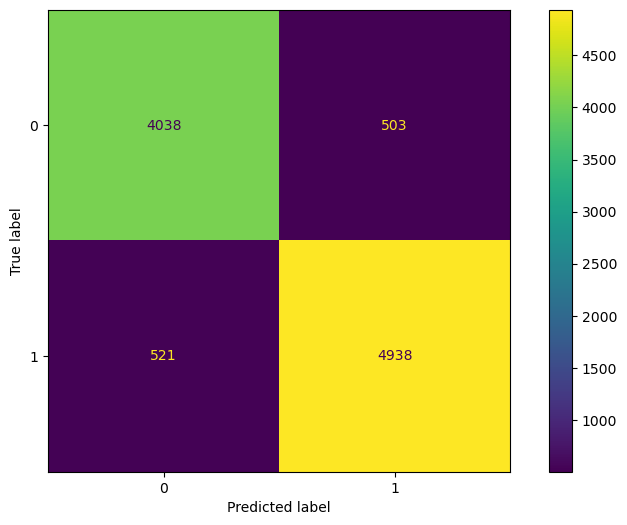

In [73]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred_test = rf.predict(x_test)
y_pred_train = rf.predict(x_train)
print("Test Recall", recall_score(y_test,y_pred_test))
print("Train Recall", recall_score(y_train,y_pred_train))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test)
plt.show()

* Due to bagging techinique the recall score of test <b> improved but still overfitting exist </b>from the difference between recall score of test and train

In [35]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      4541
           1       0.86      0.86      0.86      5459

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



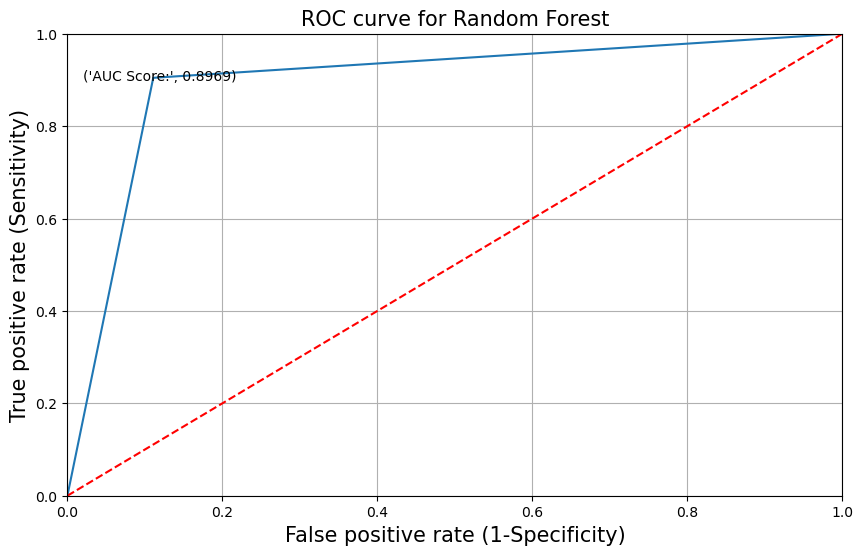

In [74]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr)
# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Random Forest', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(y_test, y_pred_test),4)))
                               
# plot the grid
plt.grid(True)

### Feature Importance of Random Forest 

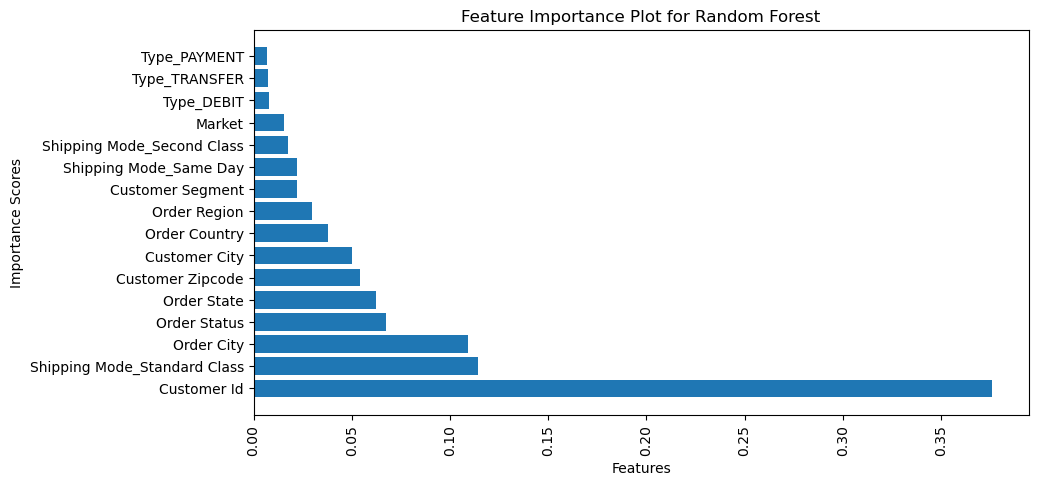

In [75]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
importance_scores = rf.feature_importances_
feature_names = list(x_train.columns)
sorted_indices = importance_scores.argsort()[::-1]
importance_scores_sorted = importance_scores[sorted_indices]
feature_names_sorted = [feature_names[i] for i in sorted_indices]
plt.figure(figsize=(10, 5))
plt.barh(feature_names_sorted, importance_scores_sorted)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Scores")
plt.title("Feature Importance Plot for Random Forest")
plt.show()

##  ADA BOOST

Test Recall 0.8631617512364902
Train Recall 0.8615097262083732


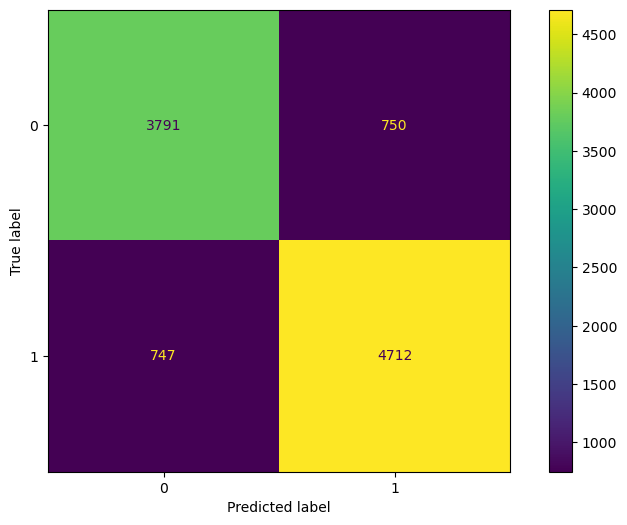

In [76]:
ad = AdaBoostClassifier()
ad.fit(x_train,y_train)
y_pred_test = ad.predict(x_test)
y_pred_train = ad.predict(x_train)
print("Test Recall", recall_score(y_test,y_pred_test))
print("Train Recall", recall_score(y_train,y_pred_train))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test)
plt.show()

In [38]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      4541
           1       0.86      0.86      0.86      5459

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



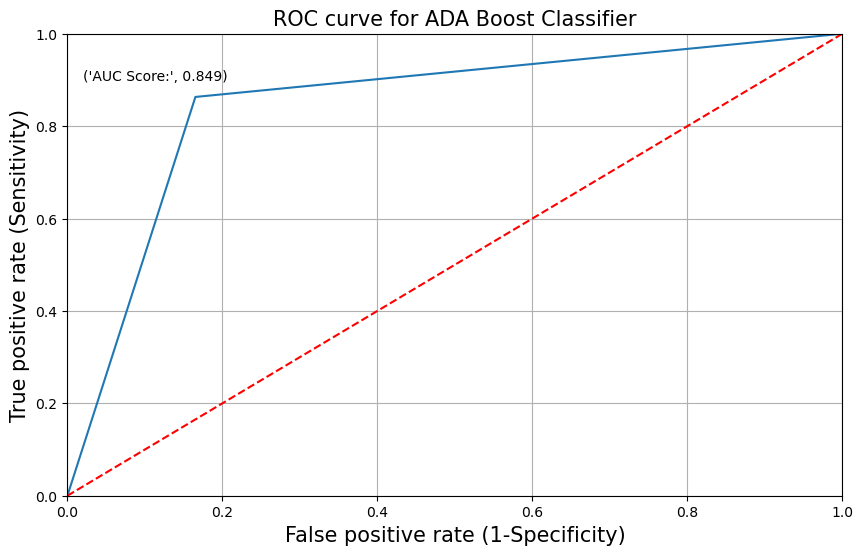

In [77]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr)
# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for ADA Boost Classifier', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(y_test, y_pred_test),4)))
                               
# plot the grid
plt.grid(True)

###  Feature Importance of  ADA BOOST 

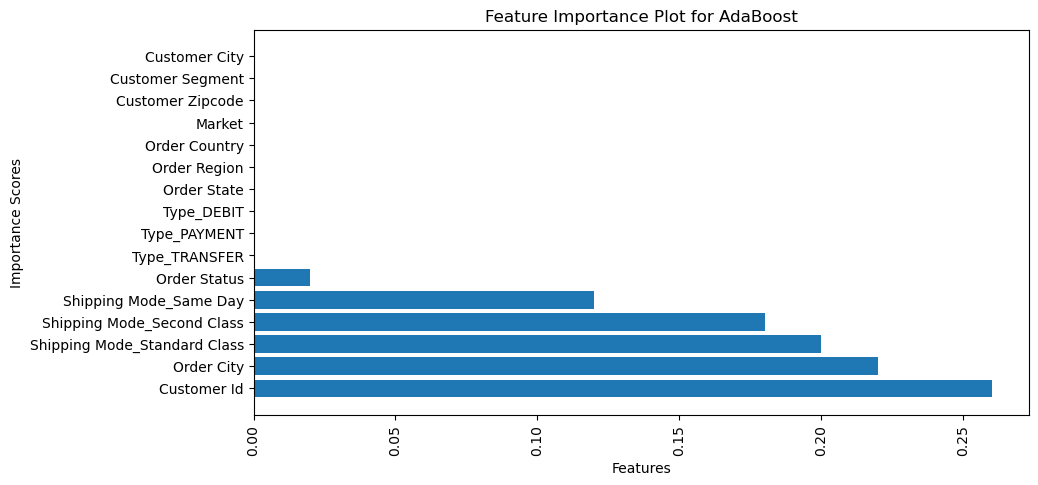

In [78]:
ad = AdaBoostClassifier()
ad.fit(x_train,y_train)
importance_scores = ad.feature_importances_
feature_names = list(x_train.columns)
sorted_indices = importance_scores.argsort()[::-1]
importance_scores_sorted = importance_scores[sorted_indices]
feature_names_sorted = [feature_names[i] for i in sorted_indices]
plt.figure(figsize=(10, 5))
plt.barh(feature_names_sorted, importance_scores_sorted)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Scores")
plt.title("Feature Importance Plot for AdaBoost")
plt.show()

## Gradient Boost Classifier

Test Recall 0.8583989741710936
Train Recall 0.8613275021639105


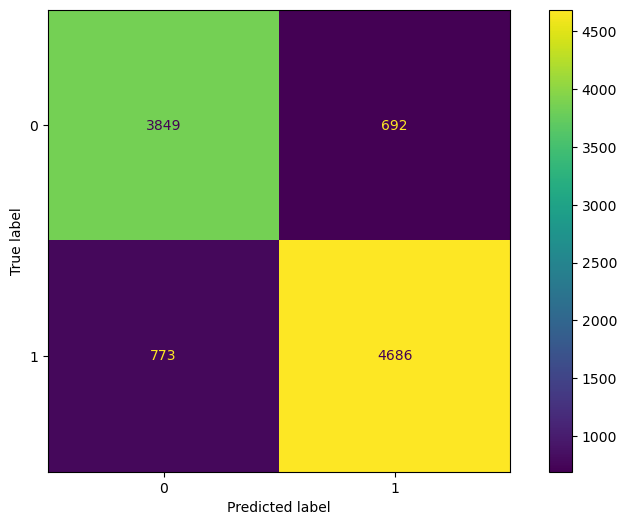

In [79]:
GB = GradientBoostingClassifier()
GB.fit(x_train,y_train)
y_pred_test = GB.predict(x_test)
y_pred_train = GB.predict(x_train)
print("Test Recall", recall_score(y_test,y_pred_test))
print("Train Recall", recall_score(y_train,y_pred_train))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test)
plt.show()

In [41]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      4541
           1       0.87      0.86      0.86      5459

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



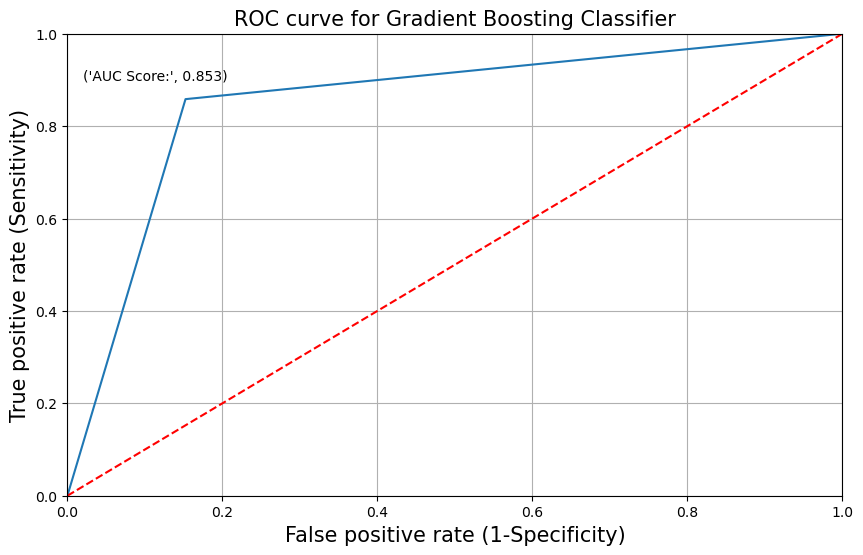

In [80]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr)
# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Gradient Boosting Classifier', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(y_test, y_pred_test),4)))
                               
# plot the grid
plt.grid(True)

###  Feature Importance of Gradient Boost Classifier

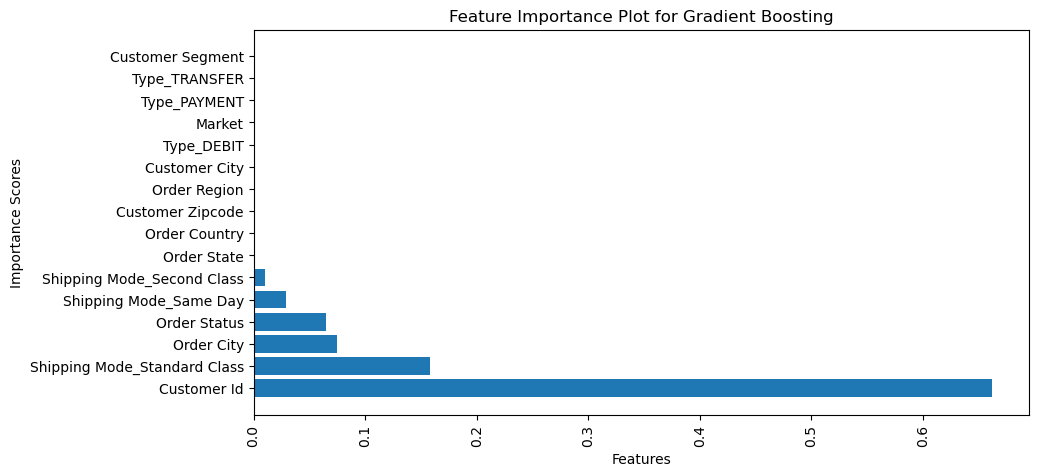

In [81]:
GB = GradientBoostingClassifier()
GB.fit(x_train,y_train)
importance_scores = GB.feature_importances_
feature_names = list(x_train.columns)
sorted_indices = importance_scores.argsort()[::-1]
importance_scores_sorted = importance_scores[sorted_indices]
feature_names_sorted = [feature_names[i] for i in sorted_indices]
plt.figure(figsize=(10, 5))
plt.barh(feature_names_sorted, importance_scores_sorted)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Scores")
plt.title("Feature Importance Plot for Gradient Boosting")
plt.show()


## XG Boost Classifier

Test Recall 0.8659095072357574
Train Recall 0.8951756184228509


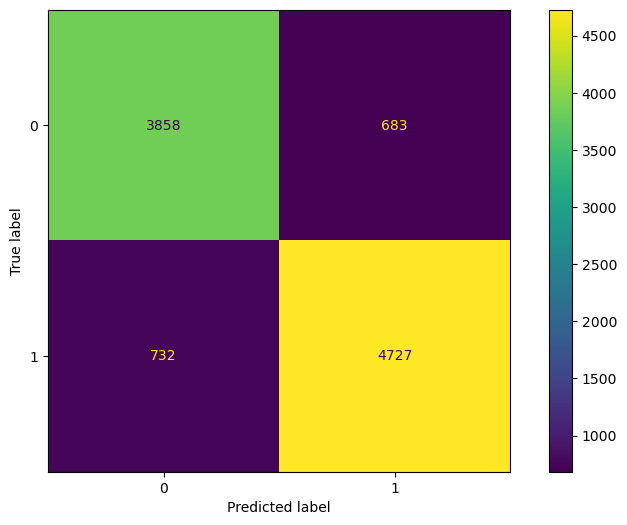

In [82]:
XGB = XGBClassifier()
XGB.fit(x_train,y_train)
y_pred_test = XGB.predict(x_test)
y_pred_train = XGB.predict(x_train)
print("Test Recall", recall_score(y_test,y_pred_test))
print("Train Recall", recall_score(y_train,y_pred_train))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test)
plt.show()

In [44]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      4541
           1       0.87      0.87      0.87      5459

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



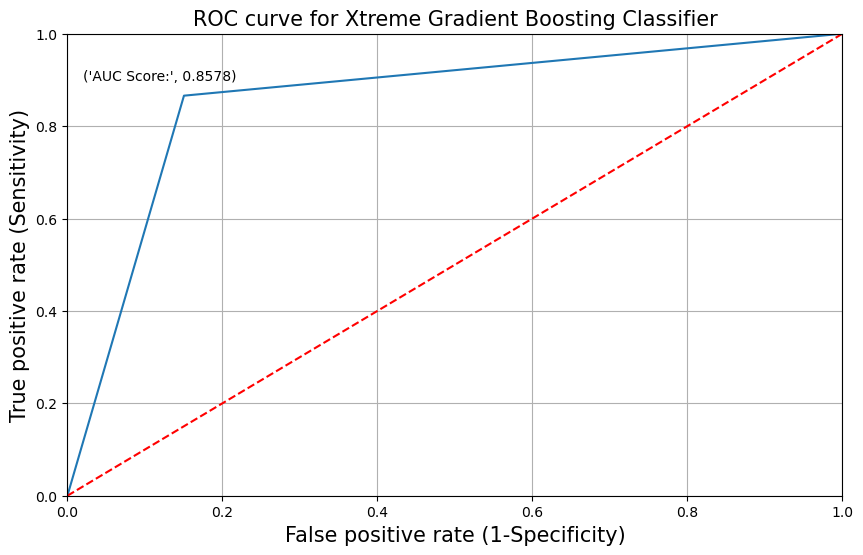

In [83]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr)
# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Xtreme Gradient Boosting Classifier', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(y_test, y_pred_test),4)))
                               
# plot the grid
plt.grid(True)

###  Feature Importance of XG Boost Classifier

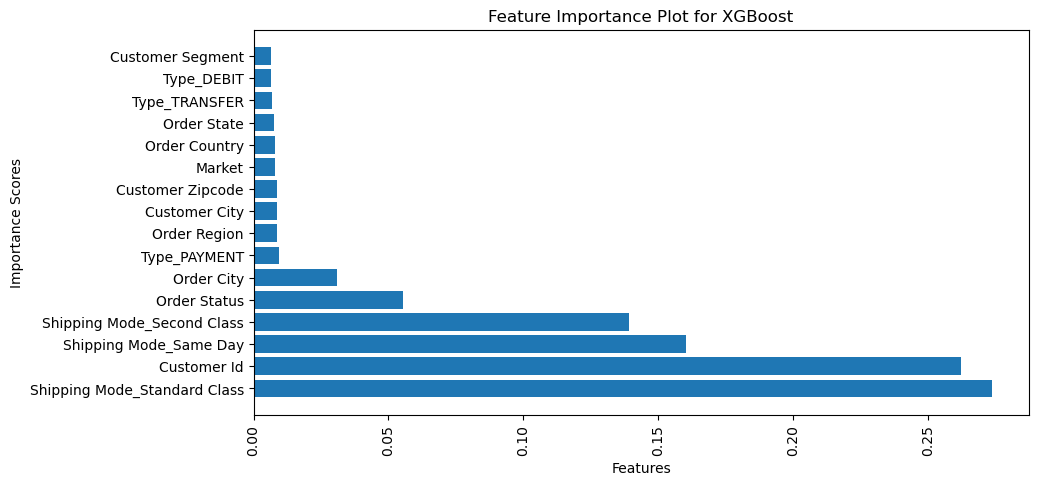

In [84]:
XGB = XGBClassifier()
XGB.fit(x_train,y_train)

importance_scores = XGB.feature_importances_

feature_names = list(x_train.columns)
sorted_indices = importance_scores.argsort()[::-1]
importance_scores_sorted = importance_scores[sorted_indices]
feature_names_sorted = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 5))
plt.barh(feature_names_sorted, importance_scores_sorted)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Scores")
plt.title("Feature Importance Plot for XGBoost")
plt.show()

## SUMMARY FOR ABOVE ALL MODELS :

In [175]:

clfs = {
      'RandomForest':RandomForestClassifier(),
      'AdaBoost': AdaBoostClassifier(),
      'GradientBoost': GradientBoostingClassifier(),
      'XGBoost': XGBClassifier(),
        'BaggingRF': BaggingClassifier(base_estimator=RandomForestClassifier()),
       'BaggingAda': BaggingClassifier(base_estimator=AdaBoostClassifier()),
       'BaggingGB': BaggingClassifier(base_estimator=GradientBoostingClassifier()),
       'BaggingXGB': BaggingClassifier(base_estimator=XGBClassifier()),
        'GaussianNB': GaussianNB()}

model_report = pd.DataFrame(columns = ["Model","Train_Accuracy_score","Test_Accuracy_score","Train_Recall_score","Test_Recall_score"])

for clf, clf_name in list(zip(clfs.values(), clfs.keys())):
    clf.fit(x_train,y_train)
    y_pred_prob_test = clf.predict(x_test)
    y_pred_test = [1 if i > 0.5 else 0 for i in y_pred_prob_test]
    y_pred_prob_train = clf.predict(x_train)
    y_pred_train = [1 if i > 0.5 else 0 for i in y_pred_prob_train]
    
    print('Fitting the model .......', clf_name)
    t= pd.Series({
        'Model': clf_name,
      'Train_Accuracy_score':accuracy_score(y_train,y_pred_train),
        'Test_Accuracy_score':accuracy_score(y_test,y_pred_test),
        'Train_Recall_score':recall_score(y_train,y_pred_train),
        'Test_Recall_score':recall_score(y_test,y_pred_test)
        
    })
    model_report = model_report.append(t,ignore_index=True)
#Focusing mainly on recall score so we sort by recall score to get our best model
model_report = model_report.sort_values(by='Test_Recall_score', ascending=False)
model_report

Fitting the model ....... RandomForest
Fitting the model ....... AdaBoost
Fitting the model ....... GradientBoost
Fitting the model ....... XGBoost
Fitting the model ....... BaggingRF
Fitting the model ....... BaggingAda
Fitting the model ....... BaggingGB
Fitting the model ....... BaggingXGB
Fitting the model ....... GaussianNB


,Model,Train_Accuracy_score,Test_Accuracy_score,Train_Recall_score,Test_Recall_score
8,GaussianNB,0.750475,0.7491,0.95285,0.95567
0,RandomForest,0.9983,0.897,0.998132,0.905111
4,BaggingRF,0.9801,0.8935,0.97909,0.899982
7,BaggingXGB,0.897775,0.864,0.895631,0.867375
3,XGBoost,0.89745,0.8585,0.895176,0.86591
1,AdaBoost,0.8518,0.8503,0.86151,0.863162
5,BaggingAda,0.854975,0.8521,0.860917,0.860597
2,GradientBoost,0.8595,0.8535,0.861328,0.858399
6,BaggingGB,0.860175,0.8539,0.861282,0.858399


# Rough Model 2 :

In [85]:
df_model_2 = df_sample.copy()
df_model_2.head()

,Type,Late_delivery_risk,Customer City,Customer Id,Customer Segment,Customer Zipcode,Market,Order City,Order Country,Order Region,Order State,Order Status,Shipping Mode
0,DEBIT,1,Taylor,17,Consumer,48180.0,LATAM,Sorocaba,Brasil,South America,São Paulo,COMPLETE,Standard Class
1,TRANSFER,1,Caguas,8889,Consumer,725.0,Europe,Leicester,Reino Unido,Northern Europe,Inglaterra,PROCESSING,Standard Class
2,CASH,0,Lynwood,10701,Consumer,90262.0,USCA,San Luis Obispo,Estados Unidos,West of USA,California,CLOSED,Standard Class
3,CASH,1,Caguas,830,Consumer,725.0,Pacific Asia,Kabul,Afganistán,South Asia,Kabul,CLOSED,Same Day
4,PAYMENT,1,Caguas,10490,Corporate,725.0,LATAM,Managua,Nicaragua,Central America,Managua,PENDING_PAYMENT,First Class


### Encoding :

In [86]:
# dropping Market,Order Country,Order region,Order state
df_model_2.drop(["Customer Segment","Order Country","Order State"],axis=1,inplace=True)

* we did all <b> target encoding </b> with features we plug probability of positive class to each type in catogory

In [88]:
en_cols = df_model_2.columns.drop(["Late_delivery_risk","Order Status","Shipping Mode","Type","Market"])
Tar_encode_dict = Target_encode_test(df_model_2,en_cols)
map_categories_encode(df_model_2,Tar_encode_dict)
df_final = pd.get_dummies(df_model_2,drop_first=True)
x = df_final.drop("Late_delivery_risk",axis=1)
y = df_final["Late_delivery_risk"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=34)
print(f"x_train {x_train.shape}")
print(f"x_test {x_test.shape}")
print(f"y_train {y_train.shape}")
print(f"y_test {y_test.shape}")

x_train (40000, 23)
x_test (10000, 23)
y_train (40000,)
y_test (10000,)


In [89]:
df_final.head(3)

,Late_delivery_risk,Customer City,Customer Id,Customer Zipcode,Order City,Order Region,Type_DEBIT,Type_PAYMENT,Type_TRANSFER,Market_Europe,Market_LATAM,Market_Pacific Asia,Market_USCA,Order Status_CLOSED,Order Status_COMPLETE,Order Status_ON_HOLD,Order Status_PAYMENT_REVIEW,Order Status_PENDING,Order Status_PENDING_PAYMENT,Order Status_PROCESSING,Order Status_SUSPECTED_FRAUD,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class
0,1,0.588235,0.428571,0.588235,0.666667,0.534044,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,1,0.546353,0.571429,0.546353,0.700000,0.544673,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0.518519,0.400000,0.518519,0.000000,0.523765,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1


In [167]:
# checking for all vanila model
clfs = {
      'RandomForest':RandomForestClassifier(),
      'AdaBoost': AdaBoostClassifier(),
      'GradientBoost': GradientBoostingClassifier(),
      'XGBoost': XGBClassifier(),
        'BaggingRF': BaggingClassifier(base_estimator=RandomForestClassifier()),
       'BaggingAda': BaggingClassifier(base_estimator=AdaBoostClassifier()),
       'BaggingGB': BaggingClassifier(base_estimator=GradientBoostingClassifier()),
       'BaggingXGB': BaggingClassifier(base_estimator=XGBClassifier()),
        'GaussianNB': GaussianNB()}

model_report = pd.DataFrame(columns = ["Model","Train_Accuracy_score","Test_Accuracy_score","Train_Recall_score","Test_Recall_score"])

for clf, clf_name in list(zip(clfs.values(), clfs.keys())):
    clf.fit(x_train,y_train)
    y_pred_prob_test = clf.predict(x_test)
    y_pred_test = [1 if i > 0.5 else 0 for i in y_pred_prob_test]
    y_pred_prob_train = clf.predict(x_train)
    y_pred_train = [1 if i > 0.5 else 0 for i in y_pred_prob_train]
    
    print('Fitting the model .......', clf_name)
    t= pd.Series({
        'Model': clf_name,
      'Train_Accuracy_score':accuracy_score(y_train,y_pred_train),
        'Test_Accuracy_score':accuracy_score(y_test,y_pred_test),
        'Train_Recall_score':recall_score(y_train,y_pred_train),
        'Test_Recall_score':recall_score(y_test,y_pred_test)
        
    })
    model_report = model_report.append(t,ignore_index=True)
#Focusing mainly on recall score so we sort by recall score to get our best model
model_report = model_report.sort_values(by='Test_Recall_score', ascending=False)
model_report

Fitting the model ....... RandomForest
Fitting the model ....... AdaBoost
Fitting the model ....... GradientBoost
Fitting the model ....... XGBoost
Fitting the model ....... BaggingRF
Fitting the model ....... BaggingAda
Fitting the model ....... BaggingGB
Fitting the model ....... BaggingXGB
Fitting the model ....... GaussianNB


,Model,Train_Accuracy_score,Test_Accuracy_score,Train_Recall_score,Test_Recall_score
8,GaussianNB,0.571425,0.5674,1.0,1.0
0,RandomForest,0.99555,0.8937,0.995627,0.902729
4,BaggingRF,0.975175,0.8865,0.974762,0.897234
1,AdaBoost,0.8498,0.8443,0.870256,0.868657
5,BaggingAda,0.850075,0.8445,0.866566,0.865726
7,BaggingXGB,0.89345,0.8592,0.889344,0.862612
3,XGBoost,0.89525,0.858,0.890939,0.862246
6,BaggingGB,0.858075,0.8532,0.85987,0.858216
2,GradientBoost,0.857775,0.8505,0.861783,0.858033


# Rough Model 3 :

* Same encoding we did with feature engineering with K-Mens clustering

In [ ]:

df_model_4 = df_sample.copy()
df_model_4.drop(["Customer Segment","Order Country","Order State","Market","Order Region"],axis=1,inplace=True)

### Encoding :

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generate some random data
# Define the range of k values to test
k_values = range(1, 10)

# Initialize empty list to store within-cluster sum of squares (WCSS)
wcss = []

# Loop over k values and fit KMeans model for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_long_lat.values)
    wcss.append(kmeans.inertia_)

# Plot the WCSS for each k value
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.title('Elbow plot for KMeans clustering')
plt.show()

In [ ]:
# Silhoutte Score
n_clusters = [3, 4, 5, 6,7,8,9,10,11,12,13]
for K in n_clusters:
    cluster = KMeans (n_clusters= K, random_state= 10)
    predict = cluster.fit_predict(df_long_lat.values)
    score = silhouette_score(df_long_lat.values, predict, random_state= 10)
    print ("For {} clusters the silhouette score is {})".format(K,score))

In [ ]:
new_clusters = KMeans(n_clusters = 3, random_state = 10)
new_clusters.fit(df_long_lat.values)
# append the cluster label for each point in the dataframe 'df_cust'
df_model_4['Cluster'] = new_clusters.labels_

In [ ]:
df_model_4['Cluster'] = df_model_4['Cluster'].astype(object)

In [ ]:
target = pd.crosstab(df_model_4["Cluster"],df_model_4["Late_delivery_risk"]).values
print("---Dependency with target: ",stats.chi2_contingency(target)[1])

In [ ]:
en_cols = df_model_4.columns.drop(["Late_delivery_risk","Shipping Mode","Type"])
Tar_encode_dict = Target_encode_test(df_model_4,en_cols)
map_categories_encode(df_model_4,Tar_encode_dict)
df_final = pd.get_dummies(df_model_4,drop_first=True)
x = df_final.drop("Late_delivery_risk_1",axis=1)
y = df_final["Late_delivery_risk_1"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=34)
print(f"x_train {x_train.shape}")
print(f"x_test {x_test.shape}")
print(f"y_train {y_train.shape}")
print(f"y_test {y_test.shape}")

In [ ]:
# checking for all vanila model
clfs = {
      'RandomForest':RandomForestClassifier(),
      'AdaBoost': AdaBoostClassifier(),
      'GradientBoost': GradientBoostingClassifier(),
      'XGBoost': XGBClassifier(),
        'BaggingRF': BaggingClassifier(base_estimator=RandomForestClassifier()),
       'BaggingAda': BaggingClassifier(base_estimator=AdaBoostClassifier()),
       'BaggingGB': BaggingClassifier(base_estimator=GradientBoostingClassifier()),
       'BaggingXGB': BaggingClassifier(base_estimator=XGBClassifier()),
        'GaussianNB': GaussianNB()}

model_report = pd.DataFrame(columns = ["Model","Accuracy_score","Recall_score","F1_score"])

for clf, clf_name in list(zip(clfs.values(), clfs.keys())):
    clf.fit(x_train,y_train)
    y_pred_prob = clf.predict(x_test)
    y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
    print('Fitting the model .......', clf_name)
    t= pd.Series({
        'Model': clf_name,
        'Accuracy_score': accuracy_score(y_test, y_pred),
        'Recall_score':recall_score(y_test,y_pred),
        'F1_score': f1_score(y_test, y_pred)
    })
    model_report = model_report.append(t,ignore_index=True)
#Focusing mainly on recall score so we sort by recall score to get our best model
model_report = model_report.sort_values(by='Recall_score', ascending=False)
model_report

### Models 1 gives better results than Models 2 and  Models 3

* In Models 1, <b> Xg boost </b> is best model and generalised model.

# Hyperparameter Tunning :

In [ ]:
xgb_model = xgb.XGBClassifier()
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameters and their ranges for RandomizedSearchCV
param_distributions = {'n_estimators': np.arange(100,500,100),
                       
                       'max_depth': ["none",1,2,3,4,5],
                       'subsample': np.arange(0.5, 1.0, 0.05),
                       'gamma': np.arange(0, 5)}

# Create the RandomizedSearchCV object
rs = RandomizedSearchCV(xgb_model, param_distributions, cv=5, n_iter=50, n_jobs=-1, random_state=42)

# Fit the model with the training data
rs.fit(x_train, y_train.values.ravel())

# Print the best hyperparameters and the corresponding mean cross-validated score
print("Best Hyperparameters: ", rs.best_params_)
print("Best Score: ", rs.best_score_)

Best Hyperparameters:  {'subsample': 0.9500000000000004, 'n_estimators': 400, 'max_depth': 4, 'gamma': 1}
Best Score:  0.8615

Test Recall 0.8659095072357574
Train Recall 0.8951756184228509


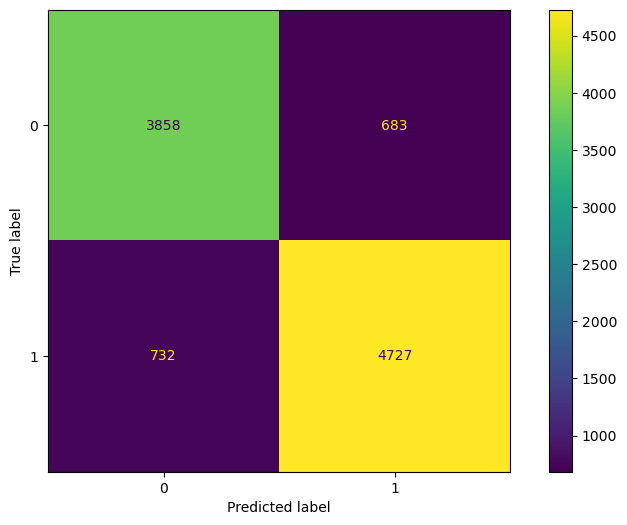

In [122]:
XGB = XGBClassifier()
XGB.fit(x_train,y_train)
y_pred_test = XGB.predict(x_test)
y_pred_train = XGB.predict(x_train)
print("Test Recall", recall_score(y_test,y_pred_test))
print("Train Recall", recall_score(y_train,y_pred_train))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test)
plt.show()

In [123]:
y_pred_prob_test = XGB.predict(x_test)
y_pred_test = [1 if i > 0.5 else 0 for i in y_pred_prob_test]
y_pred_prob_train = XGB.predict(x_train)
y_pred_train = [1 if i > 0.5 else 0 for i in y_pred_prob_train]

print('Train_Accuracy_score',accuracy_score(y_train,y_pred_train))
print('Test_Accuracy_score',accuracy_score(y_test,y_pred_test))
print('Train_Recall_score',recall_score(y_train,y_pred_train))
print('Test_Recall_score',recall_score(y_test,y_pred_test))

Train_Accuracy_score 0.89745
Test_Accuracy_score 0.8585
Train_Recall_score 0.8951756184228509
Test_Recall_score 0.8659095072357574


In [124]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      4541
           1       0.87      0.87      0.87      5459

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



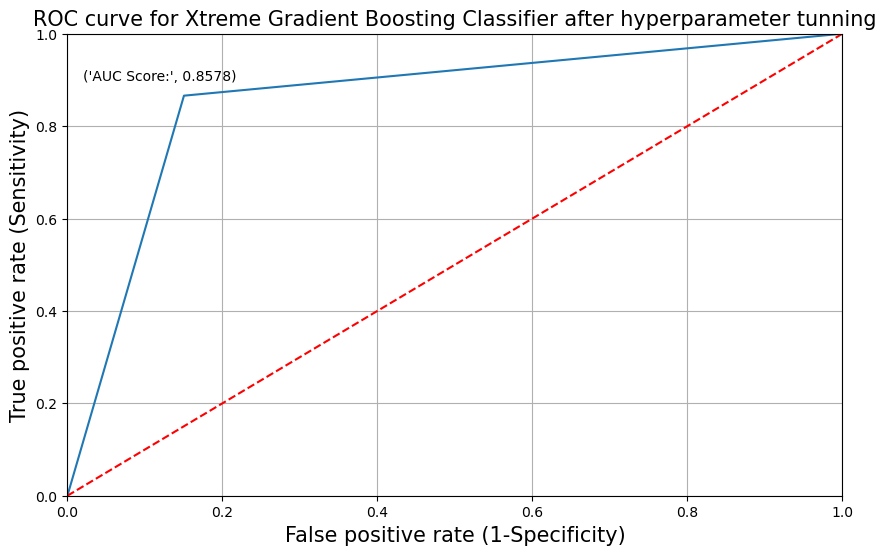

In [125]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr)
# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Xtreme Gradient Boosting Classifier after hyperparameter tunning', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(y_test, y_pred_test),4)))
                               
# plot the grid
plt.grid(True)

### After Hyperparameter Tunning

Test Recall 0.8615130976369298
Train Recall 0.8673864516422942


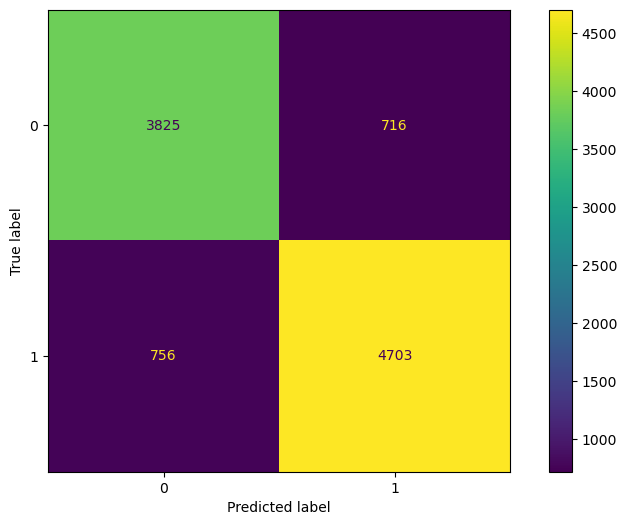

In [108]:
XGB = XGBClassifier(n_estimators= 400, max_depth= 4, gamma=1)
XGB.fit(x_train,y_train)
y_pred_test = XGB.predict(x_test)
y_pred_train = XGB.predict(x_train)
print("Test Recall", recall_score(y_test,y_pred_test))
print("Train Recall", recall_score(y_train,y_pred_train))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test)
plt.show()

In [109]:
y_pred_prob_test = XGB.predict(x_test)
y_pred_test = [1 if i > 0.5 else 0 for i in y_pred_prob_test]
y_pred_prob_train = XGB.predict(x_train)
y_pred_train = [1 if i > 0.5 else 0 for i in y_pred_prob_train]

print('Train_Accuracy_score',accuracy_score(y_train,y_pred_train))
print('Test_Accuracy_score',accuracy_score(y_test,y_pred_test))
print('Train_Recall_score',recall_score(y_train,y_pred_train))
print('Test_Recall_score',recall_score(y_test,y_pred_test))

Train_Accuracy_score 0.861975
Test_Accuracy_score 0.8528
Train_Recall_score 0.8673864516422942
Test_Recall_score 0.8615130976369298


In [110]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      4541
           1       0.87      0.86      0.86      5459

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



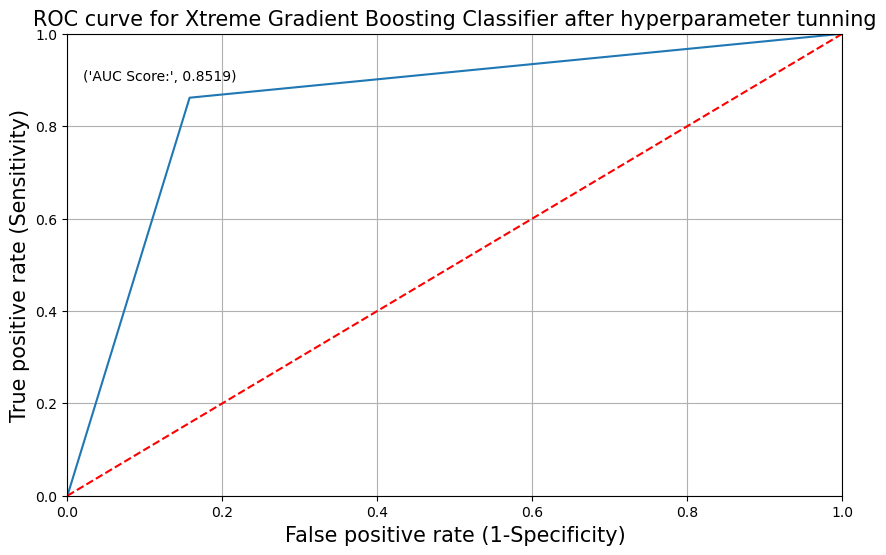

In [112]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr)
# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Xtreme Gradient Boosting Classifier after hyperparameter tunning', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(y_test, y_pred_test),4)))
                               
# plot the grid
plt.grid(True)